In [1]:
# Importing relevant libraries
%load_ext lab_black
import warnings
import urllib

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [2]:
# Loading the data
data_2021 = pd.read_csv("../data/airbnb_listings_2021.csv")
data_2021.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [3]:
# Dropping irrelevant columns and those that are unethical to use
data_2021.drop(
    [
        "id",
        "host_name",
        "last_review",
        "license",
        "name",
        "host_id",
        "number_of_reviews",
        "reviews_per_month",
        "number_of_reviews_ltm",
    ],
    axis=1,
    inplace=True,
)

In [4]:
# Replacing the missing values for numerical columns with mean and mode
data_2021["price"] = data_2021["price"].fillna(data_2021["price"].mean())
data_2021["minimum_nights"] = data_2021["minimum_nights"].fillna(
    data_2021["minimum_nights"].mean()
)
data_2021["calculated_host_listings_count"] = data_2021[
    "calculated_host_listings_count"
].fillna(data_2021["calculated_host_listings_count"].mean())
data_2021["availability_365"] = data_2021["availability_365"].fillna(
    data_2021["availability_365"].mean()
)
data_2021["neighbourhood_group"] = data_2021["neighbourhood_group"].fillna(
    data_2021["neighbourhood_group"].mode()[0]
)
data_2021.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [5]:
# label encoding categorical columns
label_encoder = LabelEncoder()
data_2021["neighbourhood_group"] = label_encoder.fit_transform(
    data_2021["neighbourhood_group"]
)
data_2021["neighbourhood"] = label_encoder.fit_transform(data_2021["neighbourhood"])
data_2021["room_type"] = label_encoder.fit_transform(data_2021["room_type"])

In [6]:
# Remove outliers
z_scores = stats.zscore(data_2021)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
new_data = data_2021[filtered_entries]

In [7]:
# Scaling the data
scaler = StandardScaler()
# scaler.fit(new_data)
scaled_features = scaler.fit_transform(new_data)
scaled_features_data = pd.DataFrame(
    scaled_features, index=new_data.index, columns=new_data.columns
)

In [8]:
# Creating train and test data
X = scaled_features_data.drop("price", axis=1)
y = scaled_features_data["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25
)

In [9]:
# list of alphas to tune
par = {"alpha": np.logspace(-5, 1, 100)}
lasso = Lasso()
Lasso_model = GridSearchCV(
    estimator=lasso,
    param_grid=par,
    scoring="neg_mean_absolute_error",
    cv=3,
    return_train_score=True,
    verbose=1,
)
Lasso_model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
       1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,
       3.05385551e-05, 3.51119173e-05, 4.03701726e-05, 4.64158883e-05,
       5.33669923e-05, 6.13590727e-05, 7.05480231e-05, 8.11130831e-05,
       9.32603347e-05, 1.07226722e-04, 1.23284674e-04, 1....
       7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
       1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
       2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
       3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
       6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [10]:
Lasso_model_result = pd.DataFrame(Lasso_model.cv_results_)

In [11]:
# Best Value of Alpha
alpha_value = Lasso_model.best_params_
alpha_value

{'alpha': 0.007054802310718645}

In [12]:
sel_val = alpha_value["alpha"]
lasso2 = Lasso(alpha=sel_val)
lasso2.fit(X_train, y_train)

# making prediction
y_train_pred = lasso2.predict(X_train)
y_test_pred = lasso2.predict(X_test)

# R2 Square

lasso_train_r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
lasso_test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print("R2 SCORE for LASSO regression on TRAIN data is : ", lasso_train_r2)
print("R2 SCORE for LASSO regression on TEST data is : ", lasso_test_r2)

R2 SCORE for LASSO regression on TRAIN data is :  0.24184358904660375
R2 SCORE for LASSO regression on TEST data is :  0.2447582511064359


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


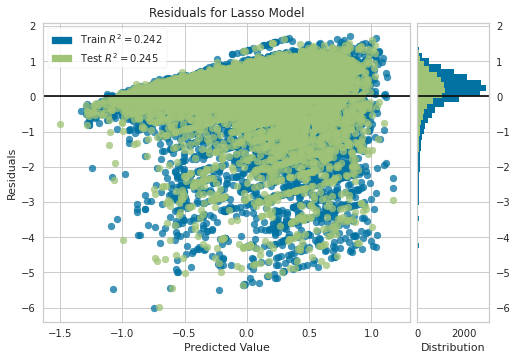

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [13]:
lasso = ResidualsPlot(lasso2)

lasso.fit(X_train, y_train)  # Fit the training data to the visualizer
lasso.score(X_test, y_test)  # Evaluate the model on the test data
lasso.show()

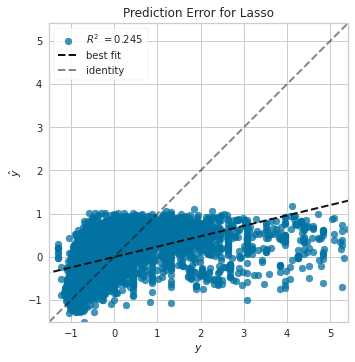

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [14]:
# Prediction error graph for the lasso model
lasso = PredictionError(lasso2)

lasso.fit(X_train, y_train)  # Fitting training data
lasso.score(X_test, y_test)  # Using test data to evaluate the model
lasso.show()

FeatureImportances(ax=<AxesSubplot:>,
                   estimator=Lasso(alpha=0.007054802310718645), relative=False)

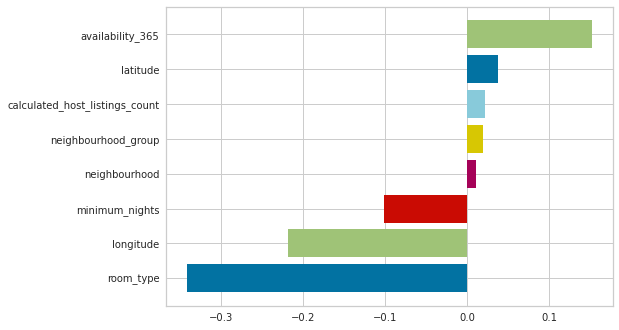

In [15]:
fetures = FeatureImportances(lasso2, relative=False)
fetures.fit(X_train, y_train)

In [16]:
# Lasso model selected features
model_parameters = list(lasso2.coef_)
model_parameters.insert(0, lasso2.intercept_)
cols = X_train.columns
cols.insert(0, "const")
lasso_coef = pd.DataFrame(list(zip(cols, model_parameters)))
lasso_coef.columns = ["Feature", "Coefficient"]

# sorting values
lasso_coef.sort_values(by="Coefficient", ascending=True).head(10)

,Feature,Coefficient
5,minimum_nights,-0.341920
4,room_type,-0.217984
6,calculated_host_listings_count,-0.102021
0,neighbourhood_group,0.002161
2,latitude,0.010301
1,neighbourhood,0.019268
7,availability_365,0.021541
3,longitude,0.036996


Text(0.5, 0, 'Index')

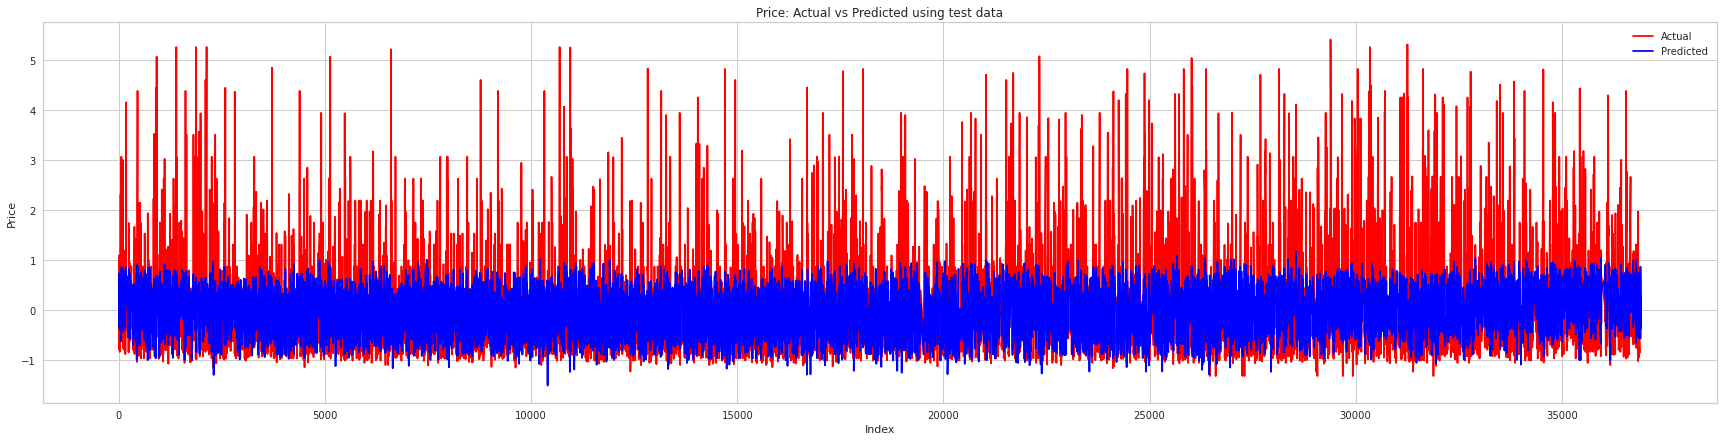

In [17]:
# actual vs predicted price using test data
fig, ax = plt.subplots(figsize=(30, 7))
sns.lineplot(x=y_test.index, y=y_test, label="Actual", color="red", ax=ax)
sns.lineplot(x=y_test.index, y=y_test_pred, label="Predicted", color="blue", ax=ax)
ax.set_title("Price: Actual vs Predicted using test data")
ax.set_ylabel("Price")
ax.set_xlabel("Index")